<a href="https://colab.research.google.com/github/Shra1surya/embedded-ai-model-export/blob/main/pytorch_onnx_quantization_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install onnx onnxruntime torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.onnx
import os

print("Torch version:", torch.__version__)


Torch version: 2.6.0+cu124


A small CNN with two convolutional layers, two fully connected layers. Perfect for testing ONNX and quantization. Runs fast and fits in embedded constraints.

In [3]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(1,8,3,1)
    self.conv2 = nn.Conv2d(8,16,3,1)
    self.fc1 = nn.Linear(5*5*16, 50)
    self.fc2 = nn.Linear(50,10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2)
    x = x.view(-1, 5*5*16)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

✅ Step 3: Load Pretrained Model or Train It (Quick)

You can skip training and load a pretrained version — but for completeness, do this:

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=64,
    shuffle=True
)

model = SimpleCNN()
optimizer =torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(2):
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch+1} completed.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.53MB/s]


Epoch 1 completed.
Epoch 2 completed.


Step4: Export to ONNX (Open Neural Network Exchange)

In [6]:
# Switch model to evaluation mode before export
model.eval()

# Create a dummy input — same shape as one MNIST image: (batch_size=1, channels=1, height=28, width=28)
dummy_input = torch.randn(1, 1, 28, 28)


# Export the model to ONNX
torch.onnx.export(
    model,                      # Your trained model
    dummy_input,                # Input tensor
    "mnist_model.onnx",         # Output ONNX file name
    export_params=True,         # Store trained weights
    opset_version=11,           # ONNX version
    do_constant_folding=True,   # Optimize constants
    input_names=['input'],      # Optional naming
    output_names=['output']
)

print("Exported to mnist_model.onnx")

✅ Exported to mnist_model.onnx


Exporting ONNX → It lets you take a model trained in PyTorch (or TensorFlow) and run it anywhere — including embedded runtimes (ONNX Runtime, TVM, Edge Impulse, etc.)

Step 5: Load and Run Inference with ONNX Runtime

In [9]:
import onnx
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model = onnx.load("mnist_model.onnx")
onnx.checker.check_model(onnx_model)
print(" ONNX model is valid")

# Create ONNX Runtime session
ort_session = ort.InferenceSession("mnist_model.onnx")

# Use a sample MNIST image for inference
sample_input = torch.randn(1, 1, 28, 28)
input_numpy = sample_input.numpy()

# Run inference
outputs = ort_session.run(None, {"input": input_numpy})
predicted_digit = np.argmax(outputs[0])

print(f"Predicted Digit: {predicted_digit}")

 ONNX model is valid
Predicted Digit: 2


Alternative: Load a real MNIST image and visualization

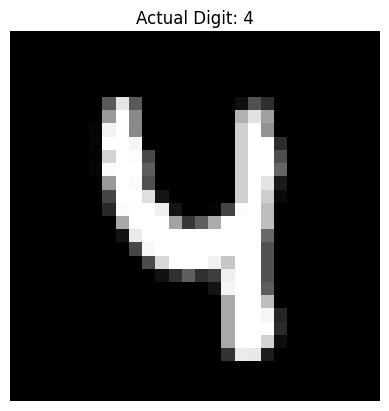

ONNX Prediction: 4 | Actual Label: 4


In [11]:
import matplotlib.pyplot as plt

#load one real sample from the MNIST test set
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train = False, download = True, transform = transform),
    batch_size = 1,
    shuffle=True
)

# Get one sample and its label
data_iter = iter(test_loader)
real_sample, real_label = next(data_iter)

# Plot the image
plt.imshow(real_sample[0][0], cmap="gray")
plt.title(f"Actual Digit: {real_label.item()}")
plt.axis("off")
plt.show()

# Prepare the sample for ONNX Inference
real_input_numpy = real_sample.numpy()
onnx_output = ort_session.run(None, {"input": real_input_numpy})
predicted_digit = np.argmax(onnx_output[0])

print(f"ONNX Prediction: {predicted_digit} | Actual Label: {real_label.item()}")

output:
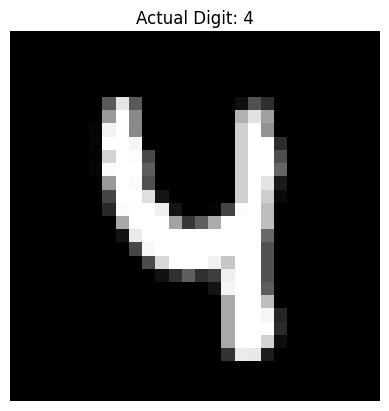
ONNX Prediction: 4 | Actual Label: 4

Step 6: Quantize the ONNX Model

In [18]:
from onnxruntime.quantization import quantize_dynamic, QuantType

quantized_model_path = "mnist_model_quant.onnx"
quantize_dynamic(
    model_input = "mnist_model.onnx",
    model_output=quantized_model_path,
    weight_type=QuantType.QInt8
)

print(f"QUantized model save to {quantized_model_path}")

QUantized model save to mnist_model_quant.onnx


Note the file size of mnist_model.onnx and mnist_model_quant.onnx
```
/content# ls -l
total 124
drwxr-xr-x 3 root root  4096 Aug  8 12:29 data
-rw-r--r-- 1 root root 88756 Aug  8 12:52 mnist_model.onnx
-rw-r--r-- 1 root root 27759 Aug  8 13:06 mnist_model_quant.onnx
drwxr-xr-x 1 root root  4096 Aug  6 13:39 sample_data
```



Step 1: Compare Model Sizes (real and dummy data)

In [12]:
!ls -lh mnist_model*.onnx # with real data

-rw-r--r-- 1 root root 87K Aug  8 12:52 mnist_model.onnx
-rw-r--r-- 1 root root 28K Aug  8 13:06 mnist_model_quant.onnx


Step 2: Benchmark Inference Time

In [16]:
import time

# Run inference multiple times for averaging
def benchmark_model(session, input_data, runs=100):
  start = time.time()
  for _ in range(runs):
    _ = session.run(None, {"input": input_data})
  end = time.time()
  avg_time_ms = (end - start) * 1000 / runs
  return avg_time_ms

# Run both original and quantized models
ort_session_orig = ort.InferenceSession("mnist_model.onnx")
ort_session_quant = ort.InferenceSession("mnist_model_quant.onnx")

real_input_numpy = real_sample.numpy()

avg_time_orig = benchmark_model(ort_session_orig, real_input_numpy)
avg_time_quant = benchmark_model(ort_session_quant, real_input_numpy)


print(f"Original model inference time: {avg_time_orig:.3f} ms")
print(f"Quantized model inference time: {avg_time_quant:.3f} ms")

NotImplemented: [ONNXRuntimeError] : 9 : NOT_IMPLEMENTED : Could not find an implementation for ConvInteger(10) node with name '/conv1/Conv_quant'

Let's try a different quantization method that might be compatible with the current ONNX Runtime version. We can try dynamic quantization with `QuantType.QUInt8` which might be more widely supported.

In [19]:
from onnxruntime.quantization import quantize_dynamic, QuantType

quantized_model_path_uint8 = "mnist_model_quant_uint8.onnx"
quantize_dynamic(
    model_input="mnist_model.onnx",
    model_output=quantized_model_path_uint8,
    weight_type=QuantType.QUInt8
)

print(f"Quantized model saved to {quantized_model_path_uint8}")

# Now, let's try to benchmark this new quantized model
import time

def benchmark_model(session, input_data, runs=100):
  start = time.time()
  for _ in range(runs):
    _ = session.run(None, {"input": input_data})
  end = time.time()
  avg_time_ms = (end - start) * 1000 / runs
  return avg_time_ms

ort_session_orig = ort.InferenceSession("mnist_model.onnx")
ort_session_quant_uint8 = ort.InferenceSession(quantized_model_path_uint8)

# Use a sample MNIST image for inference
sample_input = torch.randn(1, 1, 28, 28)
input_numpy = sample_input.numpy()

avg_time_orig = benchmark_model(ort_session_orig, input_numpy)
avg_time_quant_uint8 = benchmark_model(ort_session_quant_uint8, input_numpy)


print(f"Original model inference time: {avg_time_orig:.3f} ms")
print(f"Quantized (UInt8) model inference time: {avg_time_quant_uint8:.3f} ms")

Quantized model saved to mnist_model_quant_uint8.onnx
Original model inference time: 0.023 ms
Quantized (UInt8) model inference time: 0.043 ms


In [22]:
!mkdir -p embedded_ai_project
!mkdir -p embedded_ai_project/models
!mv mnist_model*.onnx embedded_ai_project/models/
!mv sample_data embedded_ai_project/ 2>/dev/null

mv: cannot stat 'mnist_model*.onnx': No such file or directory


In [23]:
from google.colab import files
files.download('pytorch_onnx_quantization_demo.ipynb')

FileNotFoundError: Cannot find file: pytorch_onnx_quantization_demo.ipynb